## Bootstrapping
Using a `KNN-Regressor` to train the model and then predict the values of the test dataset we use the bootstrapping method to reduce the uncertainty and find out which is the optimal hyperparameter K for the predcition 


### Import Libraries

In [1]:
# load libraries:
library(reshape2)
library(ggplot2)

Warning message:
"package 'reshape2' was built under R version 3.6.3"Warning message:
"package 'ggplot2' was built under R version 3.6.3"

### Import data

In [2]:
train.data <- read.csv(file = "data/train.csv")[,1] # First Column 
train.label <- read.csv(file = "data/train.csv")[,2] # Second Column
test.data <- read.csv(file = "data/test.csv")[,1] # First Column
test.label <- read.csv(file = "data/test.csv")[,2] # Second Column

### KNN Regresson Function 

In [3]:
# KNN regressor function
knn.reg <- function(train.data, train.label, test.data, K=3, distance = 'manhattan'){
    
    # Convert the data to dataframe
    if(!is.data.frame(train.data)){ # If train.data is not a dataframe
        train.data = data.frame(train.data) # Build a dataframe with a vector 
        names(train.data)  <- c('n') # Change the name of the unique column to match with test 
    }
    if(!is.data.frame(test.data)){ # If test.data is not a dataframe
        test.data = data.frame(test.data) # Build a dataframe with a vector 
        names(test.data)  <- c('n') # Change the name of the unique column to match with test 
    }
    
    
    # Get the number of rows of each dataframe
    train.len <- nrow(train.data)
    test.len <- nrow(test.data)
    
    # Creating the returning variable
    test.label <- c()
    
    # Calculate distances between samples and get the important part of the matrix
    dist <- as.matrix(dist(rbind(test.data, train.data), method = distance))[1:test.len, (test.len+1):(test.len+train.len)]
    
    ## for each test sample
    for (i in 1:train.len){
        # Find its K nearest neighbours from training samples
       
        nn <- as.data.frame(sort(dist[,i], index.return = TRUE))[1:K,2]

        ### And calculate the predicted labels with the mean
        test.label[i]<- mean(train.label[nn])        
    }
    
    ## return the class labels as output
    return (test.label)
}

### Bootstrapping Function
Bootstrapping is a powerful statistical tool that helps us to measure the uncertainty in the prediction of a model. In this task, we implement this technique to assess variations in the prediction of KNN regressor.

In [10]:
boot_KNN <- function (train.data, train.label, test.data, K, N, L){
    
    indx <- matrix(nrow=L, ncol=N) # Store the index of bootstraping
    miss <- data.frame('K'=1:L, 'L'=1:L, 'N'=1:L, 'MSE_test'=rep(0,L)) # Create the dataframe to store results

    ### for every dataset sizes:
    for (l in 1:L){
        indx  <- sample(x=length(train.data), size=N, replace = TRUE) # Sample with replacement 

        #### save the value of k and l
        miss[l,'N'] <- N
        miss[l,'K'] <- K
        miss[l,'L'] <- l
        #### calculate and record the train and test missclassification rates
        miss[l,'MSE_test'] <-  mean((knn.reg(train.data[indx], train.label[indx], test.data, K)  - test.label)^2, na.rm=T)
    } 
    return(miss)
}

### Experiment #1
Applying the bootstrapping for KNN regression with times = 30 (the number of subsets), size = 60 (the size of each subset), and change K=1,..,20 (the neighbourhood size). We create a boxplot where the x-axis is K, and the y-axis is the average 
test error (and the uncertainty around it) corresponding to each K. 

In [11]:
miss <- data.frame('K'=1, 'L'=1, 'N'=1, 'MSE_test'=1) # Create a random dataframe to append the results
for(K in 1:20){ # For K from 1 to 20
    miss <- rbind(miss, boot_KNN(train.data, train.label, test.data, K, 60, 30))
}
miss <- miss[-1,] # Delete the first value that was create to append the results
miss <- subset(miss, select=c(-N)) # Delete column N as it is constant in this task
options(warn=-1)

### Visualization

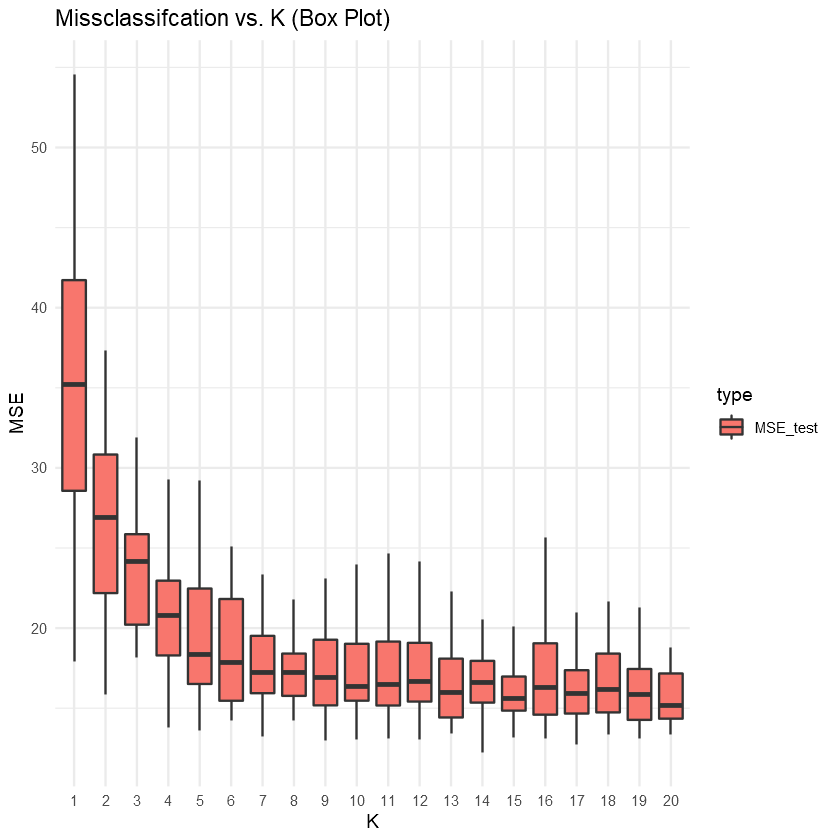

In [12]:
# plot misclassification percentage for train and test data sets
miss.m <- melt(miss, id=c('K', 'L')) # reshape for visualization
names(miss.m) <- c('K', 'L', 'type', 'miss') # rename the columns
ggplot(data=miss.m[miss.m$type=='MSE_test',], aes(factor(K), miss,fill=type)) + geom_boxplot(outlier.shape = NA)  + 
    scale_color_discrete(guide = guide_legend(title = NULL)) + 
    ggtitle('Missclassifcation vs. K (Box Plot)') + theme_minimal() + ylab("MSE")  + xlab("K")
# ignore the warnings (because of ignoring outliers)
options(warn=-1)

From the plot shown, we can observe that the relationship between MSE and K is strongly negative when the K increases the MSE decreases leading us to think the more neighbors we use in the KNN regression the more accurate the prediction is because we get a smaller MSE. Even though we have to be careful with the overfitting as we could observe in question 2.
It also can be seen that after K = 9 the graph seems to be almost flat. Therefore, when we choose a K greater than 9 we can get pretty much the same MSE but we could be overfitting the model

IV. [5 marks] Load Task1B_train.csv and Task1B_test.csv sets. Apply your 
bootstrapping for KNN regression with K=5 (the neighbourhood size),
times = 50 (the number of subsets), and change sizes = 5, 10, 15,..., 75 (the 
size of each subset). Now create a boxplot where the x-axis is ‘sizes’, and 
the y-axis is the average test error (and the uncertainty around it) 
corresponding to each value of ‘sizes’. Save the plot in your Jupyter 
Notebook file for Question 3.4

### Experiment #2
Now with the same values as before we get the MSE for each different N

In [13]:
miss <- data.frame('K'=1, 'L'=1, 'N'=1,'MSE_test'=1) # Create a random dataframe to append the results
for(N in seq(5, 75, 5)){ # For K from 1 to 20
    miss <- rbind(miss, boot_KNN(train.data, train.label, test.data, 5, N, 50))
}
miss <- miss[-1,] # Delete the first value that was create to append the results
miss <- subset(miss, select=c(-K)) # Delete column K as it is constant in this task

### Visualization

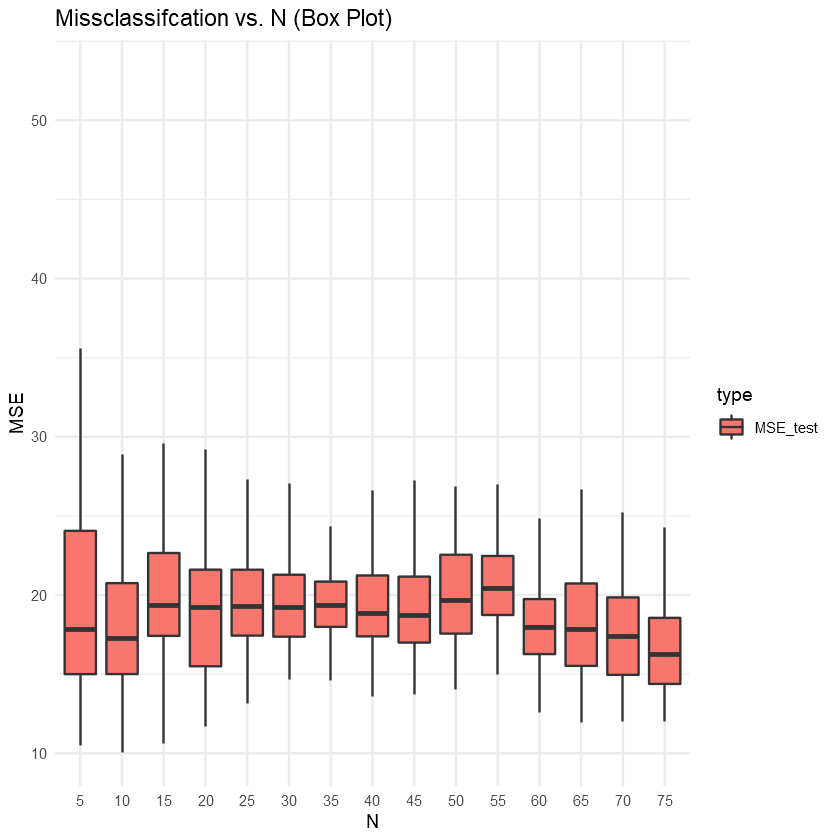

In [14]:
miss.m <- melt(miss, id=c('N', 'L')) # reshape for visualization
names(miss.m) <- c('N', 'L', 'type', 'miss')
ggplot(data=miss.m[miss.m$type=='MSE_test',], aes(factor(N), miss,fill=type)) + geom_boxplot(outlier.shape = NA)  + 
    scale_color_discrete(guide = guide_legend(title = NULL)) + 
    ggtitle('Missclassifcation vs. N (Box Plot)') + theme_minimal() + ylab("MSE") + xlab("N")
# ignore the warnings (because of ignoring outliers)
options(warn=-1)

From the previou plot the MSE seems to be indepent from the N, as we can not find any pattern that could tell us if it is better to use a small or big sample of training data.

One of the reasons could be that the data is pretty balanced. It does not matter if the training dataset size is 5 rows of 75 rows, the error seems to be pretty constant. If the dataset is not balanced, meaning have too many outliers or noise in the data, when we have small N the error could be higher than when we have a big N. Because the when we have more information we can train better our model
